**ML COURSE 2024-2025**
# LAB4: Classification with KNN and Logistic Regression

In this notebook you will implement K-Nearest Neighbors and Logistic Regression for classification tasks.

#### Summary


In [1]:
!git clone https://github.com/Chiara2804/ML_2024-25.git

Cloning into 'ML_2024-25'...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

| Task                   | Target                 | Example                     |
|------------------------|-----------------------|-----------------------------|
| Regression        | Continuous Values     | `{3.2, 5.7, 8.9}`            |
| Classification     | Unordered/Ordered Categories  | `{🐶 Dog, 🐱 Cat, 🐰 Rabbit}`        |



## Classification metrics

<span style="color: #4abde8;">**Accuracy / classification rate**</span>
$$
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{total number of predictions}}
$$

In [3]:
def accuracy(y_true, y_pred):
    """
    Args:
    y_true: array of true labels. Shape (n_samples, ) or (n_samples, 1)
    y_pred: array of predicted labels. Shape (n_samples, ) or (n_samples, 1)
    """
    total_predictions = len(y_true)
    is_correct = (y_true == y_pred)
    n_correct_pred = np.sum(is_correct)
    accuracy = n_correct_pred / total_predictions
    return accuracy


true_labels = np.array(['cat', 'dog', 'cat'])
predicted_labels = np.array(['cat', 'dog', 'dog'])
acc = accuracy(true_labels, predicted_labels)
print(acc)

0.6666666666666666


<span style="color: #1663aa;">**Confusion Matrix**</span>

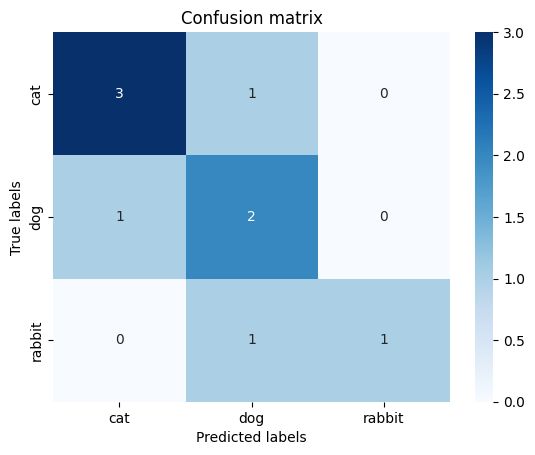

In [4]:
def get_confusion_matrix(y_true, y_pred, classes):
    """
    Args:
    y_true: array of true labels. Shape (n_samples, ) or (n_samples, 1)
    y_pred: array of predicted labels. Shape (n_samples, ) or (n_samples, 1)
    classes: list of class labels
    """
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            confusion_matrix[i, j] = np.sum((y_true == classes[i]) & (y_pred == classes[j]))
    return confusion_matrix


classes = ['cat', 'dog', 'rabbit']
true_labels      = np.array(['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'rabbit', 'rabbit' ])
predicted_labels = np.array(['cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'rabbit', 'dog'])

confusion_matrix = get_confusion_matrix(true_labels, predicted_labels, classes)
sns.heatmap(confusion_matrix, annot=True, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

### Classification metrics for Binary Classification (Positive/Negative or 1/0 classes)
| Actual \ Predicted | Positive (P) | Negative (N) |
|-------------------|-------------|-------------|
| **Positive (P)**  | True Positive (TP) ✅ | False Negative (FN) ❌ |
| **Negative (N)**  | False Positive (FP) ❌ | True Negative (TN) ✅ |


Then we can define:
- <span style="color: #4abde8;">**Accuracy**</span>: $\frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$

- <span style="color: #f4a43a;">**Specificity**</span>: $\frac{\text{TN}}{\text{TN} + \text{FP}}$

- <span style="color: #0ea782;">**Precision**</span>: $\frac{\text{TP}}{\text{TP} + \text{FP}}$

- <span style="color: #d586ab;">**Recall**</span>: $\frac{\text{TP}}{\text{TP} + \text{FN}}$

In [5]:
def TP_TN_FP_FN(y_true, y_pred):
    """
    Intuitive way to calculate TP, TN, FP, FN
    """
    positive = (y_true == 1)            # array of the same shape as y_true, with True if y_true is pos/1 and False otherwise
    negative = (y_true == 0)            # array of the same shape as y_true, with True if y_true is neg/0 and False otherwise
    pred_positive = (y_pred == 1)       # array with True if the predicted label is pos/1, 0 otherwise
    pred_negative = (y_pred == 0)       # array with True if the predicted label is neg/0, 0 otherwise

    # element-wise boolean operation that returns 1 if both are True/1, 0 otherwise
    TP = np.sum(positive & pred_positive)  # True Positives
    TN = np.sum(negative & pred_negative)  # True Negatives
    FP = np.sum(negative & pred_positive)  # False Positives
    FN = np.sum(positive & pred_negative)  # False Negatives
    return TP, TN, FP, FN


def specificity(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return TN / (TN + FP)

def precision(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return TP / (TP + FP)

def recall(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return TP / (TP + FN)


y_true = np.array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1])
y_pred = np.array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0])
TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
acc = accuracy(y_true, y_pred)
spec = specificity(y_true, y_pred)
prec = precision(y_true, y_pred)
rec = recall(y_true, y_pred)

print("True Positives: ", TP, " True Negatives: ", TN, " False Positives: ", FP, " False Negatives: ", FN)
print("Accuracy: ", acc)
print("Specificity: ", spec)
print("Precision: ", prec)
print("Recall: ", rec)

True Positives:  4  True Negatives:  2  False Positives:  1  False Negatives:  3
Accuracy:  0.6
Specificity:  0.6666666666666666
Precision:  0.8
Recall:  0.5714285714285714


## Stratified Splitting

I.e., how to split data into training and test sets while keeping the same proportions of different classes (i.e. if your dataset has 70% cats and 30% dogs, the training and test sets will also have about 70% dogs and 30% cats). This helps the model to generalize better.

In [6]:
def stratified_train_test_split(X, y, train_prop):
    """
    Split randomly the dataset into training and test sets while preserving class proportions.

    Args:
    X: array of samples. Shape (n_samples, n_features)
    y: array of labels. Shape (n_samples, ) or (n_samples, 1)
    train_prop: proportion of samples to include in the training set. Must be between 0 and 1.

    Returns:
    X_train: array of training samples. Shape (n_train_samples, n_features)
    X_test: array of test samples. Shape (n_test_samples, n_features)
    y_train: array of training labels. Shape (n_train_samples, ) or (n_train_samples, 1)
    y_test: array of test labels. Shape (n_test_samples, ) or (n_test_samples, 1)
    """
    unique_classes = np.unique(y)                           # get unique class labels (i.e., the different classes)

    #liste vuote per memorizzare gli indici
    train_indices = []
    test_indices = []

    for cls in unique_classes:
        indices = np.where(y == cls)[0]                     # find indices of samples belonging to class cls
        np.random.shuffle(indices)                          # shuffle the indices for randomness
        split_idx = int(indices.shape[0] * train_prop)      # determine split index

        #lo posso fare perchè prima ho fatto lo shuffle
        cls_train_indices = indices[:split_idx].tolist()    # get the first split_idx indices for training for class cls
        cls_test_indices = indices[split_idx:].tolist()     # get the remaining indices for testing for class cls

        train_indices = train_indices + cls_train_indices   # concatenate the training indices for all classes
        test_indices = test_indices + cls_test_indices      # concatenate the test indices for all classes

    # shuffle again to avoid unintended ordering (right now the indices are ordered by class)
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

## k-Nearest Neighbors

Key idea: find a predefined number k of training samples closests in distance to the new point, and predict the label from these:
- for classification: majority voting, i.e, the most frequent class among the k neighbors.
- for regression: average (or weighted average) of neighbors' values.

![image.png](https://www.jcchouinard.com/wp-content/uploads/2021/08/image-8.png)

Different type of distances can be used (most common: Euclidean)

In [7]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [8]:
def KNN_classifier(X_train, y_train, X_test, k, distance_metric):
    """
    Args:
    X_train: array of training samples. Shape (n_samples, n_features)
    y_train: array of training labels. Shape (n_samples,) or (n_samples, 1)
    X_test: array of test samples. Shape (n_samples_test, n_features)
    k: number of neighbors to consider
    distance_metric: 'euclidean' or 'manhattan'
    """
    n_train_samples = X_train.shape[0]
    n_test_samples = X_test.shape[0]

    y_train = y_train.flatten()                 # make sure y_train is 1D array

    # check if k>number of training samples: if so  set k to the number of training samples
    if k > n_train_samples:
        print("Warning: k > number of training samples. Setting k to number of training samples")
        k = n_train_samples

    predictions = []

    # iterate over each test sample
    for j in range(n_test_samples):
        x_test = X_test[j, :]

        # compute the distance between the each test sample and all training samples
        pairs_dist_lab = []
        for j in range(n_train_samples):
            if distance_metric == 'euclidean':
                dist = euclidean_distance(X_train[j,:], x_test)
            elif distance_metric == 'manhattan':
                dist = manhattan_distance(X_train[j,:], x_test)

            # store each pair (distance, label)
            pairs_dist_lab.append((dist, y_train[j]))

        # sort the pairs (distance, label) by distance in ascending order
        pairs_dist_lab = sorted(pairs_dist_lab, key = lambda x:x[0])

        # get the first k pairs (i.e. the k-nearest neighbors, with smallest distance)
        k_nearest = pairs_dist_lab[:k]

        # from the k pairs extract the labels
        k_nearest_labels = []
        for dist, label in k_nearest:
            k_nearest_labels.append(label)

        # get the most common label
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
        idx_max_count = np.argmax(counts)
        most_common_label = unique_labels[idx_max_count]
        predictions.append(most_common_label)

    predictions = np.array(predictions)
    return predictions

### k-NN on IRIS data

In [9]:
np.random.seed(0)

In [10]:
# Load data: IRIS considering only the features 'sepal_length', 'sepal_width' and with target 'species'
data = pd.read_csv('/content/ML_2024-25/drive/MyDrive/AA24-25ML/iris.csv')
display(data.head())
data = data[['sepal length (cm)', 'sepal width (cm)', 'species']]

# let's see what are the classes in the dataset
classes = data['species'].unique()
print("Classes: ", classes)

# Split data into X and y numpy arrays
X = data.drop('species', axis=1).to_numpy()
y = data[['species']].to_numpy()
n_samples = X.shape[0]
n_features = X.shape[1]

# check the shapes
print("X shape: ", X.shape)
print("y shape: ", y.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/ML_2024-25/drive/MyDrive/AA24-25ML/iris.csv'

<div style="background-color: lightblue; padding: 10px; color: black">
<strong> ⚠️ Warning! </strong> The expression <code>y = data[['species']].to_numpy() </code> returns a 2D array of shape (n_samples, 1), while <code>y = data['species'].to_numpy() </code> returns a 1D array of shape (n_samples,).
Both are valid, but be careful of the following:
<ol>
    <li>Ensure true labels and predicted labels have consistent shapes.</li>
    <li>Gradient computation formulas usually assume <code>y</code> is a column vector <code>(n_samples, 1)</code>.</li>
    <li>External libraries may require a 1D array instead.</li>
</ol>
Always verify shapes at each step: many errors, even silent ones, stem from mismatched dimensions!
</div>


**Tip 🕵**
If you need (and you will) to convert the labels into numerical values (e.g., _Iris-setosa_ → 0, _Iris-versicolor_ → 1, _Iris-virginica_ → 2) you can use:

In [ ]:
classes, y_numeric = np.unique(y, return_inverse=True) #converte le classi in numeri
print(y_numeric)
print(classes)

Let's see KNN in action:

In [ ]:
k_values = [1, 2, 3, 5, 10, 20, 30, 50, 100]

# MC-CV parameters
train_set_prop = 0.8
n_iter_mc_cv = 25    #standard

miss_c_rates = []

for k in k_values:
    miss_c_rates_k = []   # miss classification rate = 1 - accuracy

    # MonteCarlo Cross Validation Loop
    for i in range(n_iter_mc_cv):
        # split the data into random train and stest
        X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, train_set_prop)

        y_pred = KNN_classifier(X_train, y_train, X_test, k, 'euclidean')
        y_pred = y_pred.reshape(y_test.shape)                               # make sure y_pred has the same shape as y_test

        # calculate the accuracy
        mcr = 1- accuracy(y_test, y_pred)
        miss_c_rates_k.append(mcr)

    miss_c_rates.append(miss_c_rates_k)

# BOXPLOTS + mean values
plt.figure()
plt.boxplot(miss_c_rates, labels=k_values, showmeans=True)
plt.ylim(bottom=0)
plt.xlabel('k-values')
plt.ylabel('Miss Classification Rate')
plt.title('KNN classifier with different k-values')
plt.show()


## Logistic Regression

### Theory

#### The logistic (sigmoid)
The **logistic regression** model uses a linear combination of the input through a logistic function trasformation, also called *sigmoid*:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

$$
\sigma(x_{i}^T\beta) = \frac{1}{1+e^{-x_i^T\beta}}
$$

Since the sigmoid directly outputs numbers in (0,1], it has a probabilistic interpretation: we can consider the outputs as the probability of the positive outcome.
$$
P(y_i=1|x_i) = \sigma(x_i^T\beta)
$$
$$
P(y_i=0|x_i) = 1-\sigma(x_i^T\beta)
$$
hence:
$$
\hat{y_i} =
\begin{cases}
    1, & \text{if } \sigma(x_i^T\beta) \geq 0.5 \\
    0, & \text{if } \sigma(x_i^T\beta) < 0.5 \\
\end{cases}
$$

#### Linear vs Logistic Regression
By passing the linear function through a sigmoid function, real values are mapped in (0,1).

![Linear vs Logistic Regression](https://github.com/Chiara2804/ML_2024-25/blob/main/figures/linearVSlogistic.png?raw=1)

- 🟨 Yellow Square: z = -10 , y' = 0
- 🔴 Red Dot: z = 0, y' = 0.5
- 💜⭐ Purple Star: z = 5, y' = 0.99

#### Solving Logistic Regression
As in LASSO regression, there is no closed solution when a sigmoid function is applied; we need to resort to Gradient Descent.  
What is our loss function? Can we use the minimum squared error?

$$
J(\beta,y) = \textcolor{red}{\frac{1}{n}}\sum_{i=1}^n\textcolor{red}{\frac{1}{2}}(y_i-\sigma(\beta_0+\sum_{j=1}^p\beta_j x_{ij}))^2
$$

The function above is generally **NOT** convex, gradient descent doesn't work. We need to find an alternative loss (error) function.

In [ ]:
# Function that, given X_expanded and beta, computes the sigmoid of X_expanded@beta
def sigmoid(z):
    return 1 / (1+np.exp(-z))

# Minimum squared error
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

# Function that creates a synthetic dataset, with binary target
def create_dataset():
    # mean of the features
    mean = np.array([0, 0, 0])
    # covariance between the features
    cov = np.array([
        [1, 0.1, 0.5],
        [0.1, 1, 0.9],
        [0.5, 0.9, 1]])
    # number of samples
    n_samples = 100

    np.random.seed(0)
    # generate samples from a multivariate normal distribution with mean and covariance defined above
    ds = np.random.multivariate_normal(mean, cov, n_samples)

    # exclude the target
    X = ds[:, :-1]
    #consider only the last feature as target
    y = ds[:, -1]
    # binarize y (difference with respect to laboratory 3)
    y = (y > np.median(y)).astype(int)
    y = y.reshape(-1, 1)

    return X, y

In [ ]:
#create the dataset
X, y = create_dataset()
beta_fixed = [-3, 0, 30]
# consider various values for beta[1]
beta_1_vec = np.linspace(0, 50, 1000)

# compute the errors for each value of beta_1_vec
errors_mse = []
for beta_1 in beta_1_vec:
    # beta[0] and beta[2] are fixed
    beta = np.array([beta_fixed[0], beta_1, beta_fixed[2]])
    # add the column of ones to X
    X_expanded = np.hstack([np.ones((X.shape[0], 1)), X])

    # compute the sigmoid
    y_pred = sigmoid(X_expanded @ beta)
    # compute the error (MSE)
    error = mse(y.flatten(), y_pred.flatten())
    errors_mse.append(error)

# plot the errors (over the values of beta_1)
plt.plot(beta_1_vec, errors_mse)
plt.xlabel('beta_1')
plt.ylabel('MSE')
plt.title('MSE vs beta_1')
plt.grid()
plt.show()

#### Negative Log Likelihood
Metric that captures a classification error.
$$
\begin{align*}
\mathcal{L}(\beta) &= - \sum_{i=1}^{n} \left[ y_i \log \sigma\left(\sum_{j=1}^{p} \beta_j x_{ij} \right) + (1 - y_i) \log \left(1 - \sigma\left(\sum_{j=1}^{p} \beta_j x_{ij} \right)\right) \right] \\
&= - \sum_{i=1}^{n} \left[ y_i \log \sigma(x_i^\top \beta) + (1 - y_i) \log (1 - \sigma(x_i^\top \beta)) \right]
\end{align*}
$$
It's convex! We can use it compute gradient descent and fine the optimal values of $\beta$.

In [ ]:
# Negative log-likelihood
def negLogLikelihood(y, y_pred):
    # Clip predictions to avoid log(0)
    return -np.mean(y * np.log(y_pred+1e-16) + (1 - y) * np.log(1 - y_pred+1e-16))

In [ ]:
#consider various values for beta[1]
beta_1_vec = np.linspace(0, 50, 1000)

#compute the errors for each value of beta_1_vec
errors_nll = []
for beta_1 in beta_1_vec:
    #beta[0] and beta[2] are fixed
    beta = np.array([beta_fixed[0], beta_1, beta_fixed[2]])
    #add the column of ones to X
    X_expanded = np.hstack([np.ones((X.shape[0], 1)), X])
    #compute the sigmoid
    y_pred = sigmoid(X_expanded @ beta)
    #compute the error (NLL)
    error = negLogLikelihood(y.flatten(), y_pred.flatten())
    errors_nll.append(error)

#plot the errors
plt.plot(beta_1_vec, errors_nll)
plt.xlabel('beta_1')
plt.ylabel('NLL')
plt.title('NLL vs beta_1')
plt.grid()
plt.show()

#### Gradient Descent on Logistic Regression
The gradient descent is performed similarly to the gradient descent of LASSO. Main differences:
- Instead of the gradient of MSE + Lasso term, we compute the gradient of the negative log likelihood.
- Instead of computing the prediction as $y_{pred} = X\beta$, we compute it as $y_{pred} = \sigma(X\beta)$

The gradient of the negative log likelihood is:
$$
\nabla L(\beta) = \frac{X^T(\hat{y}-y)}{n}
$$
where the matrix $X$ has been expanded to include an additional column of ones at the beginning.

We do not show explicitly how the formula of the gradient is derived; if you're interested in having more details, you can find them [here](https://ml-explained.com/blog/logistic-regression-explained#deriving-the-gradient-descent-formula-for-logistic-regression-optional).

In [ ]:
def nll_gradient(X_expanded, y_true, y_pred):
    """Compute the gradient of the negative log-likelihood loss.

    Args:
    X_expanded: array of shape (n_samples, n_features + 1) with the samples and a column of ones
    y_true: array of shape (n_samples, 1) with the true labels
    y_pred: array of shape (n_samples, 1) with the predicted labels
    """
    # check if the dimensions of y_true and y_pred are correct
    assert y_true.ndim == 2, "y_true should be a column vector of shape (n_samples, 1)"
    assert y_pred.ndim == 2, "y_pred should be a column vector of shape (n_samples, 1)"

    n_samples = X_expanded.shape[0]  # Number of samples
    return (X_expanded.T@(y_pred-y_true))/n_samples  # Shape (p+1, 1)

def GD_update(beta, gradient, learning_rate):
    """Performs a gradient descent update."""
    return beta - learning_rate * gradient

def train_logistic_regression_GD(X, y, initial_learning_rate, decay_rate, n_iter):
    """Train logistic regression using gradient descent.

    Args:
    X: (n_samples, n_features) - Input features
    y: (n_samples, ) - Binary labels
    initial_learning_rate: float - Initial learning rate
    decay_rate: float - Learning rate decay factor
    n_iter: int - Number of iterations

    Returns:
    beta: (n_features + 1, 1) - Learned parameters
    """
    np.random.seed(0)
    n_samples, n_features = X.shape

    X_expanded = np.hstack([np.ones((n_samples, 1)), X])  # Add column of ones

    beta = np.random.rand(n_features + 1, 1)  # Shape (p+1, 1) for binary classification

    # Training loop
    for i in range(n_iter):
        learning_rate = initial_learning_rate/(1+decay_rate*i)  # update the learning rate
        y_pred = sigmoid(X_expanded @ beta) # Sigmoid activation for binary classification.
        gradient = nll_gradient(X_expanded, y.reshape(-1, 1), y_pred)
        beta = GD_update(beta, gradient, learning_rate)

    return beta

### Logistic Regression for multiclass classsification on IRIS data

In some cases, we want to predict the class of a sample, and the possible set of classes has cardinality greater than two. For example, in the Iris dataset, the prediction is the species, and there are three possible predictions: 'Iris-setosa', 'Iris-versicolor' and 'Iris-virginica'.

In [ ]:
#set the seed
np.random.seed(0)
# Load again the data: IRIS considering only the features 'sepal_length', 'sepal_width' and with target 'species'
data = pd.read_csv('/content/ML_2024-25/drive/MyDrive/AA24-25ML/iris.csv')
data = data[['sepal length (cm)', 'sepal width (cm)', 'species']]
classes = data['species'].unique()

# Split data into X and y numpy arrays
X = data.drop('species', axis=1).to_numpy()
y = data['species'].to_numpy()

n_samples = X.shape[0]
n_features = X.shape[1]
# check the shapes
print("X shape: ", X.shape)
print("y shape: ", y.shape)

In [ ]:
# Divide X and y into training and test sets using stratified sampling
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, 0.8)
print("Training set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])

#### One VS One
One possible strategy for solving multi-class classification is called **one vs one**. Specifically:
- For each pair of class <code>(class_1, class_2)</code> we train a classifier that distinguishes between <code>(class_1, class_2)</code> (samples that were associated with the other classes are temporally removed from the training set). If we have $K$ classes, we will have $\frac{K(K-1)}{2}$ classifiers.
- At test time, we pass the new samples to classify through each of the $\frac{K(K-1)}{2}$ classifiers.
- We count how many time each class was predicted, hence "won" against the other classes.
- We predict the class that won most frequently.
There are different ways in which ties can be handled; today, we will break them arbitrarly.

In [ ]:
def train_oneVSone(X_train, y_train , classes, learning_rate, decay_rate, n_iter):
    """
    X_train: matrix of training data
    y_train: vector of training labels
    classes: list of classes to consider

    Returns a dictionary containing the optimal parameters for each model, trained on each pair of classes using Logistic Regression
    """
    # Dictionary to store the optimal betas for each model (one for each pair of classes)
    optimal_parameters = {}

    # Iterate through class pairs and train classifiers
    pairs = [(classes[0], classes[1]), (classes[1], classes[2]), (classes[2], classes[0])]

    for class_1, class_2 in pairs:
        print(f"Training classifier for {class_1} vs {class_2}")

        # Filter training data for the selected class pair
        mask = (y_train == class_1) | (y_train == class_2)  # Boolean mask for filtering
        X_train_subset = X_train[mask]  # Select relevant samples
        y_train_subset = y_train[mask]  # Select relevant labels

        # Convert labels to 0 or 1 (1 if class_1, 0 otherwise)
        y_train_subset = np.where( y_train_subset == class_1, 1, 0).astype(int)

        # Train logistic regression model using gradient descent
        beta = train_logistic_regression_GD(X_train_subset, y_train_subset, learning_rate, decay_rate, n_iter)

        # Save model parameters
        optimal_parameters[(class_1, class_2)] = beta

    return optimal_parameters

def predict_oneVSone(X_test, y_test, optimal_parameters):
    """
    X_test : matrix of test data
    y_test : vector of test labels
    optimal_parameters : dictionary containing the optimal parameters for each model

    Returns a vector of final predictions based on majority voting of all the models trained on classes pairs using Logistic Regression
    """
    # Initialize vote counts; it contains one dictionary for each test sample
    vote_counts = [{} for _ in range(len(y_test))]  # One dictionary for each test sample

    # Evaluate classifiers on the test set
    for (class_1, class_2), beta in optimal_parameters.items(): #optimal_parameters.items() returns the tuple (key, value) for each item in the dictionary (the keys are tuples (class_1, class_2), the values are betas)
        #add column of ones to the test set
        X_test_expanded = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
        #compute the probabilities
        probabilities = sigmoid(X_test_expanded @ beta)
        #compute the prediction
        y_pred = (probabilities >= 0.5).astype(int)

        for idx in range(len(y_test)):
            pred = y_pred[idx]  # Get the predicted class label
            predicted_class = class_1 if pred else class_2 # the model predicts class_1 if pred is 1, class_2 if pred is 0

            # if the class is already in the dictionary, increment the count, otherwise add the class to the dictionary
            if predicted_class in vote_counts[idx]:
                vote_counts[idx][predicted_class] += 1
            else:
                vote_counts[idx][predicted_class] = 1

    # Determine final prediction based on majority voting
    final_predictions = []
    for i in range(len(vote_counts)):
        votes = vote_counts[i] # Get the dictionary of votes for the i-th test sample

        # Extract keys and values separately
        classes = list(votes.keys()) # Get the classes
        vote_numbers = list(votes.values()) # Get how many times each class has been predicted

        # Find the maximum vote count
        max_votes = max(vote_numbers)

        # Get all classes that have the max vote count (to handle ties)
        tied_classes = [classes[j] for j in range(len(vote_numbers)) if vote_numbers[j] == max_votes]

        # Randomly select one class in case of a tie
        predicted_class = random.choice(tied_classes)

        final_predictions.append(predicted_class)

    return final_predictions


In [ ]:
# Training hyperparameters
decay_rate = 0.0001
n_iter = 10000              # Number of iterations
learning_rate = 0.1
optimal_parameters_oneVSone = train_oneVSone(X_train, y_train, classes, learning_rate, decay_rate, n_iter)
final_predictions_oneVSone = predict_oneVSone(X_test, y_test, optimal_parameters_oneVSone)

In [ ]:
# compute accuracy of prediction
acc = accuracy(y_test, final_predictions_oneVSone)
print("Accuracy: ", acc)

#### One VS All

Another possible strategy for solving multi-class classification is called **one vs all**. Specifically:
- For each class <code>class_1</code> we train a classifier that distinguishes between <code>class_1</code> and <code>not class_1</code> (all samples from the training set are considered). If we have $K$ classes, we will have $K$ classifiers.
- At test time, we pass the new samples to classify through each of the $K$ classifiers.
- We save the confidence score (probability) derived from each classifier.
- We predict the class with the highest confidence score.

In [ ]:
def train_oneVSall(X_train, y_train, classes, learning_rate, decay_rate, n_iter):
    """
    X_train: matrix of training data
    y_train: vector of training labels
    classes: list of classes to consider

    Returns a dictionary containing the optimal parameters for each model, trained on each class using Logistic Regression
    """
    # Dictionary to store the optimal betas for each model (one for each class)
    optimal_parameters = {}

    # Iterate through each unique class and train a one-vs-all classifier
    for i in range(len(classes)):
        class_1 = classes[i]  # Get the class label

        print(f"Training classifier for {class_1} vs all")

        # Convert class labels to binary (1 if the class is class_1, 0 otherwise)
        y_train_binary = np.where(y_train == class_1, 1, 0).astype(int)  # 1 for class_1, 0 for all others

        # Train logistic regression model using gradient descent
        beta = train_logistic_regression_GD(X_train, y_train_binary, learning_rate, decay_rate, n_iter)

        # Save model parameters (betas)
        optimal_parameters[class_1] = beta  # Keyed by the class label

    return optimal_parameters

def predict_oneVSall(X_test, y_test, optimal_parameters):
    """
    X_test : matrix of test data
    y_test : vector of test labels
    optimal_parameters: dictionary containing the optimal parameters for each model

    Returns a vector of final predictions based on majority voting of all the models trained on each class using Logistic Regression
    """
    # Initialize probability dictionary for each test sample (for each sample, it will contain the probability of each class, as computed by the corresponding model)
    probabilities = [{} for _ in range(len(y_test))]

    # Iterate through each class and compute probabilities using the corresponding model (beta)
    for class_1, beta in optimal_parameters.items():
        # Predict probabilities for class_1 using the custom logistic regression
        X_test_expanded = np.hstack([np.ones((X_test.shape[0], 1)), X_test])  # Add a column of ones (bias term)
        class_probs = sigmoid(X_test_expanded @ beta)  # Compute the probabilities using the sigmoid function

        # Store probabilities in the dictionary for each test sample
        for i in range(len(y_test)):
            probabilities[i][class_1] = class_probs[i, 0]  # Assign the probability for class_1

    # Initialize final predictions list
    final_predictions = []

    # Iterate through each test sample's probability dictionary
    for probs in probabilities:
        # Extract class labels
        class_labels = list(probs.keys())

        # Extract probability values
        prob_values = list(probs.values())

        # Find the class with the highest probability
        max_index = prob_values.index(max(prob_values))
        predicted_class = class_labels[max_index]

        # Store the final prediction
        final_predictions.append(predicted_class)

    return final_predictions

In [ ]:
# Training hyperparameters
decay_rate = 0.0001
n_iter = 10000              # Number of iterations
learning_rate = 0.1
optimal_parameters_oneVSall = train_oneVSall(X_train, y_train, classes, learning_rate, decay_rate, n_iter)
final_predictions_oneVSall = predict_oneVSall(X_test, y_test, optimal_parameters_oneVSall)

In [ ]:
# Compute and print the accuracy of the predictions
acc = accuracy(y_test, final_predictions_oneVSall)
print("Accuracy: ", acc)

## Decision boundaries

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from utils import plot_decision_boundary_2d, create_2d_meshpoints, plot_probability_boundary, plot_combined_probability_boundary

In [ ]:
# 2-dimensional dataset

# Generate synthetic dataset
data = make_blobs(n_samples=100, centers=3, n_features=2, random_state=0) #make_blobs creates a synthetic dataset such that in the y target there are 3 classes and 3 clusters
assert len(data) == 2
X, y = data

n_features = X.shape[1]
resolution = 400

# Generate a dense grid of points covering the 2D feature space.
# If X has more than two features, PCA is applied to reduce it to two dimensions.
# X_grid: Flattened array of all grid points in the 2D space.
# xx, yy: Meshgrid matrices representing x and y coordinates for visualization.
# X_2d: Original dataset X, potentially reduced to 2D if necessary.
X_grid, xx, yy, X_2d = create_2d_meshpoints(X, resolution)

# Train logistic regression model using scikit-learn
# parameters: multi_class='ovr' (one-vs-rest), solver='lbfgs' (optimization algorithm), max_iter=1000 (maximum number of iterations), random_state=0 (seed)
clf = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=0)
# train the model
clf.fit(X, y)

# Define the probability function using the trained model
probability_function = clf.predict_proba

# Plot decision boundary
plot_decision_boundary_2d(X_grid, y, probability_function, xx, yy, X_2d, n_features)

# Plot probability boundary (it shows how confident the model is about its predictions)
plot_probability_boundary(probability_function, X, y)

If the features are > 2, PCA is used to plot the decision boundary in 2D: the first and the second principal components are shown.

In [ ]:
# Generate multi-class data (3 classes)
data = make_blobs(n_samples=100, centers=3, n_features=6, random_state=0) # in this case, there are 6 features
assert len(data) == 2
X, y = data

n_features = X.shape[1]
resolution = 400

# Generate a dense grid of points covering the 2D feature space.
# If X has more than two features, PCA is applied to reduce it to two dimensions.
# X_grid: Flattened array of all grid points in the 2D space.
# xx, yy: Meshgrid matrices representing x and y coordinates for visualization.
# X_2d: Original dataset X, potentially reduced to 2D if necessary.
X_grid, xx, yy, X_2d = create_2d_meshpoints(X, resolution)

# Train logistic regression model using scikit-learn
# parameters: multi_class='ovr' (one-vs-rest), solver='lbfgs' (optimization algorithm), max_iter=1000 (maximum number of iterations), random_state=0 (seed)
clf = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=0)
# train the model
clf.fit(X, y)

# Define the probability function using the trained model
probability_function = clf.predict_proba

# Plot decision boundary
plot_decision_boundary_2d(X_grid, y, probability_function, xx, yy, X_2d, n_features)

# Plot probability boundary
plot_probability_boundary(probability_function, X, y)

# combined the boundaries computed above in one figure
plot_combined_probability_boundary(probability_function, X_grid, X_2d, xx, yy, X, y, linewidth=3)

## 🏋️‍♀️ Exercises

### Binary classification with K-NN

1. Load the 'breast_cancer.csv' file in drive/MyDrive/AA24-25ML
    - Get X and y arrays. Use as target the 'target' column.
    - Divide randomly, using stratified sampling, in X_train, X_test, y_train, y_test.
2. Rewrite the K-NN classification function:
    - Such that, together with the most common labels it returns the average distance from neighbors.
    - Using only euclidean distance.
    - Be careful not to overwrite the method by choosing the same name of the one already implemented.
3. Make predictions on the test set. Use k=20.
4. Compute, by re-implementing the functions from scratch:
    - accuracy
    - specificity
    - precision
    - recall

Compare with the already implemented ones.

In [16]:
# load data
data = pd.read_csv("breast_cancer.csv")
display(data.head())

y = data['target'].values # colonna target
X = data.drop(columns='target').values # tutte le colonne tranne values

train_prop = 0.8

X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, train_prop)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [32]:
def KNN_classification_function(X_train, y_train, X_test, k, distance_metrics):
    n_train_samples = X_train.shape[0]
    n_test_samples = X_test.shape[0]

    if k > n_train_samples:
        k = n_train_samples

    predictions = []

    for i in range(n_test_samples):
        x_test = X_test[i, :]

        pairs_dist = []
        for j in range(n_train_samples):
            if distance_metrics == 'euclidean':
                dist = euclidean_distance(X_train[j,:], x_test)
            elif distance_metrics == 'manhattan':
                dist = manhattan_distance(X_train[j,:], x_test)

            pairs_dist.append([dist, y_train[i]])

        pairs_dist = sorted(pairs_dist, key = lambda x:x[0])

        k_nearest = pairs_dist[:k]
        k_nearest_labels = []

        for dist, label in k_nearest:
            k_nearest_labels.append(label)

        # get the most common label
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
        idx_max_count = np.argmax(counts)
        most_common_label = unique_labels[idx_max_count]
        predictions.append(most_common_label)

    return predictions

In [18]:
def accuracy_function(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return (TP + TN) / (TP + TN + FP + FN)

def specificity_function(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return TN / (TN + FP)

def precision_function(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return TP / ( TP + FP)

def recall_function(y_true, y_pred):
    TP, TN, FP, FN = TP_TN_FP_FN(y_true, y_pred)
    return TP / (TP + FN)

In [33]:
k = 20
y_pred = KNN_classification_function(X_train, y_train, X_test, k, 'euclidean')

acc = accuracy_function(y_true, y_pred)
spec = specificity_function(y_true, y_pred)
prec = precision_function(y_true, y_pred)
rec = recall_function(y_true, y_pred)

C:\Users\chiar\AppData\Local\Temp\ipykernel_13428\51013311.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return (TP + TN) / (TP + TN + FP + FN)
C:\Users\chiar\AppData\Local\Temp\ipykernel_13428\51013311.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return TN / (TN + FP)
C:\Users\chiar\AppData\Local\Temp\ipykernel_13428\51013311.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return TP / ( TP + FP)
C:\Users\chiar\AppData\Local\Temp\ipykernel_13428\51013311.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return TP / (TP + FN)


### Logistic Regression with Scikit-learn
Using the same dataset:
- Train a Logistic Regression model using the Scikit-learn implementation.
- Make predictions on the test set using the `.predict(...)` method.
- Compute accuracy, specificity, recall, precision and plot confusion matrix.
- Comment the results and compare with K-NN ones.
- What if we standardize data? What happens? Comment the results.